In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import lightgbm
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from lightgbm import early_stopping 

2024-11-02 13:56:26.790316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-02 13:56:26.790545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-02 13:56:26.993312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amirkabirdam/holiday.csv
/kaggle/input/amirkabirdam/dam12.csv
/kaggle/input/d/homaabedinzadeh/futuredays/90days.csv
/kaggle/input/d/homaabedinzadeh/holidayname/holidayname.csv
/kaggle/input/feature-engineering/__results__.html
/kaggle/input/feature-engineering/__notebook__.ipynb
/kaggle/input/feature-engineering/__output__.json
/kaggle/input/feature-engineering/finaldatset.csv
/kaggle/input/feature-engineering/custom.css
/kaggle/input/climate-indeices/ONI.xlsx
/kaggle/input/climate-indeices/ENSO.xlsx
/kaggle/input/climate-indeices/AMO.xlsx
/kaggle/input/climate-indeices/NAO.xlsx
/kaggle/input/climate-indeices/SOI.xlsx


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
df = pd.read_csv('/kaggle/input/feature-engineering/finaldatset.csv')


In [5]:
df.drop('DateRow', inplace=True , axis=1)

In [6]:
df.columns

Index(['soi_shift_1', 'soi_shiftdiv_1', 'soi_shift_3', 'soi_shiftdiv_3',
       'soi_shift_6', 'soi_shiftdiv_6', 'soi_shift_9', 'soi_shiftdiv_9',
       'soi_shift_12', 'soi_shiftdiv_12',
       ...
       'BareshBarf_in_shift_1_x_BareshBarf_in_shift_2',
       'BareshBarf_in_shift_1_x_BareshBarf_in_shift_3',
       'BareshBarf_in_shift_1_x_BareshBarf_in_shift_4',
       'BareshBarf_in_shift_1_x_BareshBarf_in_shift_5',
       'BareshBarf_in_shift_2_x_BareshBarf_in_shift_3',
       'BareshBarf_in_shift_2_x_BareshBarf_in_shift_4',
       'BareshBarf_in_shift_2_x_BareshBarf_in_shift_5',
       'BareshBarf_in_shift_3_x_BareshBarf_in_shift_4',
       'BareshBarf_in_shift_3_x_BareshBarf_in_shift_5',
       'BareshBarf_in_shift_4_x_BareshBarf_in_shift_5'],
      dtype='object', length=2118)

In [7]:
horizon=-15

In [8]:
target = df['Total_in'].shift(horizon)

target.dropna(inplace=True)

In [9]:
df.head()

,soi_shift_1,soi_shiftdiv_1,soi_shift_3,soi_shiftdiv_3,soi_shift_6,soi_shiftdiv_6,soi_shift_9,soi_shiftdiv_9,soi_shift_12,soi_shiftdiv_12,...,BareshBarf_in_shift_1_x_BareshBarf_in_shift_2,BareshBarf_in_shift_1_x_BareshBarf_in_shift_3,BareshBarf_in_shift_1_x_BareshBarf_in_shift_4,BareshBarf_in_shift_1_x_BareshBarf_in_shift_5,BareshBarf_in_shift_2_x_BareshBarf_in_shift_3,BareshBarf_in_shift_2_x_BareshBarf_in_shift_4,BareshBarf_in_shift_2_x_BareshBarf_in_shift_5,BareshBarf_in_shift_3_x_BareshBarf_in_shift_4,BareshBarf_in_shift_3_x_BareshBarf_in_shift_5,BareshBarf_in_shift_4_x_BareshBarf_in_shift_5
0,0.5,-1.0,0.3,-0.6,0.9,-1.8,-0.5,1.0,-0.3,0.6,...,213575.821963,220695.016028,213575.821963,220695.016028,197230.60971,190868.331977,197230.60971,197230.60971,203804.963367,197230.60971
1,0.5,-1.0,0.3,-0.6,0.9,-1.8,-0.5,1.0,-0.3,0.6,...,213575.821963,220695.016028,213575.821963,220695.016028,197230.60971,190868.331977,197230.60971,197230.60971,203804.963367,197230.60971
2,0.5,-1.0,0.3,-0.6,0.9,-1.8,-0.5,1.0,-0.3,0.6,...,213575.821963,220695.016028,213575.821963,220695.016028,197230.60971,190868.331977,197230.60971,197230.60971,203804.963367,197230.60971
3,0.5,-1.0,0.3,-0.6,0.9,-1.8,-0.5,1.0,-0.3,0.6,...,213575.821963,220695.016028,213575.821963,220695.016028,197230.60971,190868.331977,197230.60971,197230.60971,203804.963367,197230.60971
4,0.5,-1.0,0.3,-0.6,0.9,-1.8,-0.5,1.0,-0.3,0.6,...,213575.821963,220695.016028,213575.821963,220695.016028,197230.60971,190868.331977,197230.60971,197230.60971,203804.963367,197230.60971


In [10]:
y=target

x = df[:horizon]
#. drop(target,axis=1)


In [11]:
x.shape

(7290, 2118)

In [12]:
len(y)

7290

In [13]:
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x.fillna(0, inplace=True)

/tmp/ipykernel_33/781971186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_33/781971186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.fillna(0, inplace=True)


In [14]:
x.shape

(7290, 2118)

In [ ]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
XGB_predictions = pd.DataFrame(columns=['predictXGB'])


i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        model = xgb.XGBRegressor(n_estimators=10000,early_stopping_rounds=10, learning_rate=0.07,  max_depth= 15 ,colsample_bytree= 0.85,  n_jobs=4)
        
        model.fit(X_train, Y_train,sample_weight=X_train['std_TotalAbBarfVBaran_in'], eval_set=[(X_test,Y_test)],verbose=False)

    # Predictions
        test_predict = model.predict(X_test)
        train_predict = model.predict(X_train)
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
       
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        df_temp = pd.DataFrame({'predictXGB': test_predict})

        # استفاده از pd.concat برای اضافه کردن پیش‌بینی‌ها به دیتافریم اصلی
        XGB_predictions = pd.concat([XGB_predictions, df_temp], ignore_index=True)
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))

        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )

print ('mapetest:',np.mean(test_mape))




In [ ]:
XGB_predictions.shape

In [ ]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

0 349
350 696
0 696
697 1043
0 1043
1044 1390
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 0.298561
rmse: 1.2313977036666317
r2: 0.4420438858447838
mape: 0.6471344040489551
0 1390
1391 1737


/tmp/ipykernel_33/2982105990.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  LGB_predictions= pd.concat([LGB_predictions, df_temp], ignore_index=True)
/tmp/ipykernel_33/2982105990.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  TestSet= pd.concat([TestSet, test_temp], ignore_index=True)


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[65]	valid_0's l2: 0.239812
rmse: 0.5134482926390519
r2: 0.10941257512522029
mape: 0.6943029084241145
0 1737
1738 2084
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 0.0967206
rmse: 0.3511364066083695
r2: 0.8189982637378663
mape: 0.3740912890709193
0 2084
2085 2431
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[156]	valid_0's l2: 0.0537447
rmse: 0.4117460783186847
r2: 0.8168449434674291
mape: 0.17180845618264723
0 2431
2432 2778
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[124]	valid_0's l2: 0.205401
rmse: 0.46251492364247243
r2: 0.7964377470857323
mape: 0.5914759452804013
0 2778
2779 3125
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[58]	valid_0's l2: 0.188758
rmse: 0.82593

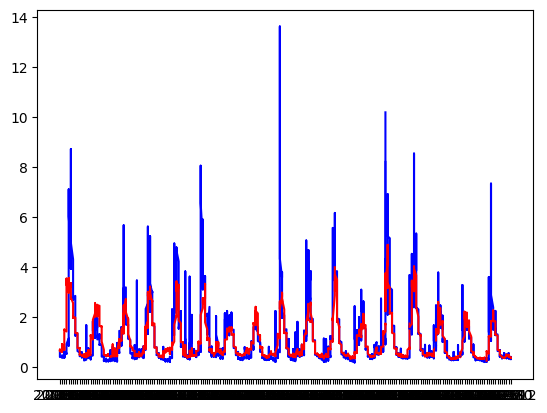

In [17]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
LGB_predictions = pd.DataFrame(columns=['predictLGB'])
TestSet=pd.DataFrame(columns=['Test'])
i=0
for train_index, test_index in tscv.split(x):
    
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    print (train_index.min(),train_index.max())
    print (test_index.min(),test_index.max())
    if i>=3:
        lgb = lightgbm.LGBMRegressor( n_estimators=10000, num_leaves=35, learning_rate=0.04, colsample_bytree=0.9,verbose=0)

        lgb.fit(X_train, Y_train,sample_weight=X_train['Total_in_shift_1'], eval_set=(X_test,Y_test),callbacks=([early_stopping(stopping_rounds=60)]))

        test_predict = lgb.predict(X_test, num_iteration=lgb.best_iteration_)
        train_predict = lgb.predict(X_train, num_iteration=lgb.best_iteration_)
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))

        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        df_temp = pd.DataFrame({'predictLGB': test_predict})
        test_temp = pd.DataFrame({'Test': Y_test})
        # استفاده از pd.concat برای اضافه کردن پیش‌بینی‌ها به دیتافریم اصلی
        LGB_predictions= pd.concat([LGB_predictions, df_temp], ignore_index=True)
        TestSet= pd.concat([TestSet, test_temp], ignore_index=True)
        
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )

print ('mapetest:',np.mean(test_mape))



In [ ]:
76.84/(76.84+ 75.55)

In [ ]:
 75.55/(76.84+ 75.55)

In [ ]:
final=pd.concat ([LGB_predictions ,XGB_predictions, TestSet], axis=1) 

In [ ]:
final['mean_column'] = ((final['predictLGB']*0.50) + (final['predictXGB']*0.49)) 

final.head()

In [ ]:
r2_score(final['Test'], final['mean_column'])


In [45]:
imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

,Importance,Feature
2058,181,meanbeforeyearTotal_in
1976,63,Total_in_rollingmin_7
519,62,TotalAbBarfVBaran_in_rollingstd_180
1609,50,DarajeHararatTar6_5_rollingmax_180
1402,44,DarajeHararatKhosk6_5_rollingmean_180
1606,37,DarajeHararatTar6_5_rollingmean_180
2004,36,Total_in_div_rollingstd_90
1470,31,DarajeHararatKhosk12_5_rollingmean_180
1982,31,Total_in_rollingmean_30
1966,31,Total_in_shift_7


In [ ]:

df.dropna(inplace=True, axis=1)
df.shape
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [ ]:
target=df['Total_in'].shift(horizon)
y=target

#x = scaled_df. drop(columns =[ target ],axis=1)#,'index'

In [ ]:
x=df.drop(columns=['Total_in'], axis=1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled_data, columns=x.columns)

In [ ]:
x=scaled_df[:horizon]

In [ ]:
x.shape

In [ ]:
y.dropna(inplace=True)

In [ ]:
y.shape

In [ ]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
predictMLP=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        mlp = MLPRegressor(hidden_layer_sizes=(1024, 512, 256), activation='relu', solver='adam', max_iter=300,learning_rate='constant', early_stopping=True,alpha=  0.0001 , batch_size=64)

        mlp.fit(X_train, Y_train )

        test_predict = mlp.predict(X_test)
        train_predict = mlp.predict(X_train)
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        predictMLP.append ( test_predict)
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))




In [ ]:
scv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
predictSVR=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        svr = SVR(kernel='rbf', C=1.0, epsilon=0.001)

        # آموزش مدل
        svr.fit(X_train, Y_train)

        # پیش‌بینی
        test_predict = svr.predict(X_test)
        train_predict = svr.predict(X_train)
        predictSVR.append(test_predict)
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.iloc[: , :-1])

In [20]:
df.dropna(inplace=True, axis=1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [26]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# فرض بر این است که df دیتافریم اصلی شماست
X = df.drop(columns=['Total_in'], axis=1)
y = df['Total_in']

# 2. Data Normalization
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.values.reshape(-1, 1))  # Reshape y to be 2D

# Define the number of time steps and reshape data
n_steps = 15
n_features = X.shape[1]

# Reshape X and y into sequences for LSTM
X_seq, y_seq = [], []
for i in range(len(X) - n_steps):
    X_seq.append(X[i:i + n_steps, :])
    y_seq.append(y[i + n_steps, 0])  # Adjust to get scalar values

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# 3. Define the LSTM model
def create_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# 4. TimeSeriesSplit Cross-Validation
tscv = TimeSeriesSplit(n_splits=20)
fold = 1

# برای ذخیره R2 و RMSE هر فولد
r2_scores = []
rmse_scores = []

for train_index, test_index in tscv.split(X_seq):
    print(f"\nTraining fold {fold}...")

    # Splitting data into train and validation sets
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    # Initialize the model
    model = create_model()

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

    # Predictions on the test set
    y_pred = model.predict(X_test)
    
    # Reshape y_pred and y_test to 1D arrays for metrics calculation
    y_pred = y_pred.reshape(-1)
    y_test = y_test.reshape(-1)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Append metrics to lists
    rmse_scores.append(rmse)
    r2_scores.append(r2)

    print(f"Fold {fold} - RMSE: {rmse}")
    print(f"Fold {fold} - R2: {r2}")
    
    fold += 1

# Print average metrics across all folds
print("\nAverage RMSE across all folds:", np.mean(rmse_scores))
print("Average R2 across all folds:", np.mean(r2_scores))



Training fold 1...
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 94s 85ms/step - loss: 27.5287 - val_loss: 0.0701
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 3.7602 - val_loss: 0.1090
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.0455 - val_loss: 0.0510
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.4195 - val_loss: 0.0466
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.2553 - val_loss: 0.0323
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1514 - val_loss: 0.0188
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1323 - val_loss: 0.0214
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1062 - val_loss: 0.0244
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0843 - val_loss: 0.0110
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0776 - val_loss: 0.0147
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0656 - val_loss: 0.0080
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0543 - val

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 7.0238 - val_loss: 0.0173
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0244 - val_loss: 0.0147
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0176 - val_loss: 0.0094
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0152 - val_loss: 0.0181
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0155 - val_loss: 0.0073
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0117 - val_loss: 0.0084
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0173 - val_loss: 0.0087
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0158 - val_loss: 0.0096
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0140 - val_loss: 0.0086
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0102 - val_loss: 0.0111
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 5.3341 - val_loss: 0.0284
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.1120 - val_loss: 0.0293
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0413 - val_loss: 0.0210
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0289 - val_loss: 0.0194
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0240 - val_loss: 0.0173
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0208 - val_loss: 0.0160
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0154 - val_loss: 0.0152
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0165 - val_loss: 0.0136
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0159 - val_loss: 0.0133
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0190 - val_loss: 0.0120
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.0128 - val_loss: 0.0130
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 1.8312 - val_loss: 0.0094
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0253 - val_loss: 0.0057
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0180 - val_loss: 0.0077
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0175 - val_loss: 0.0056
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0166 - val_loss: 0.0057
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0166 - val_loss: 0.0047
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0138 - val_loss: 0.0054
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0141 - val_loss: 0.0063
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0150 - val_loss: 0.0070
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0150 - val_loss: 0.0075
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0140 - val_loss: 0.0059
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 6.8928 - val_loss: 0.0245
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0356 - val_loss: 0.0043
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0215 - val_loss: 0.0067
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0201 - val_loss: 0.0059
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0126 - val_loss: 0.0048
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0125 - val_loss: 0.0045
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0106 - val_loss: 0.0043
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0137 - val_loss: 0.0052
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0111 - val_loss: 0.0035
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0107 - val_loss: 0.0035
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0105 - val_loss: 0.0035
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 7.9966 - val_loss: 0.0261
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0435 - val_loss: 0.0102
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0292 - val_loss: 0.0092
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0243 - val_loss: 0.0087
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0224 - val_loss: 0.0127
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0185 - val_loss: 0.0108
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0191 - val_loss: 0.0063
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0238 - val_loss: 0.0094
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0254 - val_loss: 0.0064
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0164 - val_loss: 0.0070
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0172 - val_loss: 0.0058
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 6.1769 - val_loss: 0.0104
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0437 - val_loss: 0.0061
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0183 - val_loss: 0.0052
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0135 - val_loss: 0.0044
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0121 - val_loss: 0.0039
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0105 - val_loss: 0.0040
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0099 - val_loss: 0.0032
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0092 - val_loss: 0.0032
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0083 - val_loss: 0.0032
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0082 - val_loss: 0.0036
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0085 - val_loss: 0.0042
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.3030 - val_loss: 0.0155
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0299 - val_loss: 0.0157
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0236 - val_loss: 0.0160
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0204 - val_loss: 0.0093
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0149 - val_loss: 0.0114
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0133 - val_loss: 0.0106
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0105 - val_loss: 0.0100
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0117 - val_loss: 0.0107
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0092 - val_loss: 0.0101
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0088 - val_loss: 0.0121
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 1.2625 - val_loss: 0.0033
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0150 - val_loss: 0.0052
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0136 - val_loss: 0.0032
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0111 - val_loss: 0.0022
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0108 - val_loss: 0.0029
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0104 - val_loss: 0.0024
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0094 - val_loss: 0.0024
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0097 - val_loss: 0.0027
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0085 - val_loss: 0.0028
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0076 - val_loss: 0.0023
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0094 - val_loss: 0.0019
Epoch 12/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 4.4617 - val_loss: 0.0186
Epoch 2/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0508 - val_loss: 0.0159
Epoch 3/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0456 - val_loss: 0.0112
Epoch 4/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0437 - val_loss: 0.0087
Epoch 5/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0420 - val_loss: 0.0107
Epoch 6/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0380 - val_loss: 0.0052
Epoch 7/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0241 - val_loss: 0.0050
Epoch 8/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0191 - val_loss: 0.0020
Epoch 9/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0170 - val_loss: 0.0023
Epoch 10/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0149 - val_loss: 0.0059
Epoch 11/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0150 - val_loss: 0.0049
Epoch 12/50
109/109 ━━━━━━━━━━━━━━━━━━━━ 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.7308 - val_loss: 0.0069
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0181 - val_loss: 0.0050
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0141 - val_loss: 0.0051
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - loss: 0.0112 - val_loss: 0.0047
Epoch 5/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0109 - val_loss: 0.0055
Epoch 6/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0083 - val_loss: 0.0044
Epoch 7/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0080 - val_loss: 0.0045
Epoch 8/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0078 - val_loss: 0.0042
Epoch 9/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 10/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0061 - val_loss: 0.0062
Epoch 11/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 12/50
120/120 ━━━━━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.5012 - val_loss: 0.0050
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0162 - val_loss: 0.0060
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0127 - val_loss: 0.0041
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0109 - val_loss: 0.0044
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0102 - val_loss: 0.0033
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0096 - val_loss: 0.0033
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0069 - val_loss: 0.0132
Epoch 12/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.8678 - val_loss: 0.0041
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0119 - val_loss: 0.0037
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0113 - val_loss: 0.0032
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0095 - val_loss: 0.0042
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0089 - val_loss: 0.0047
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0074 - val_loss: 0.0024
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 9/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0065 - val_loss: 0.0023
Epoch 10/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0078 - val_loss: 0.0037
Epoch 11/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0068 - val_loss: 0.0026
Epoch 12/50
142/142 ━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 1.2019 - val_loss: 0.0037
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - loss: 0.0128 - val_loss: 0.0030
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0104 - val_loss: 0.0071
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0093 - val_loss: 0.0035
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.0084 - val_loss: 0.0022
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0082 - val_loss: 0.0049
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0074 - val_loss: 0.0026
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 9/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 10/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - loss: 0.0055 - val_loss: 0.0023
Epoch 11/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0060 - val_loss: 0.0026
Epoch 12/50
152/152 ━━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 1.0411 - val_loss: 0.0104
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0226 - val_loss: 0.0060
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 0.0206 - val_loss: 0.0051
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 0.0164 - val_loss: 0.0038
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0151 - val_loss: 0.0044
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0133 - val_loss: 0.0046
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0118 - val_loss: 0.0038
Epoch 8/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0104 - val_loss: 0.0031
Epoch 9/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0090 - val_loss: 0.0029
Epoch 10/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0081 - val_loss: 0.0031
Epoch 11/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0079 - val_loss: 0.0032
Epoch 12/50
163/163 ━━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.8390 - val_loss: 0.0206
Epoch 2/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.0244 - val_loss: 0.0236
Epoch 3/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0210 - val_loss: 0.0291
Epoch 4/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0184 - val_loss: 0.0220
Epoch 5/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0148 - val_loss: 0.0113
Epoch 6/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - loss: 0.0130 - val_loss: 0.0108
Epoch 7/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0113 - val_loss: 0.0155
Epoch 8/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0103 - val_loss: 0.0068
Epoch 9/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 0.0090 - val_loss: 0.0100
Epoch 10/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 0.0084 - val_loss: 0.0101
Epoch 11/50
174/174 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0083 - val_loss: 0.0071
Epoch 12/50
174/174 ━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1.1876 - val_loss: 0.0031
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0114 - val_loss: 0.0049
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0113 - val_loss: 0.0019
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0087 - val_loss: 0.0018
Epoch 5/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0088 - val_loss: 0.0015
Epoch 6/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0077 - val_loss: 0.0019
Epoch 7/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0073 - val_loss: 0.0030
Epoch 8/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0070 - val_loss: 0.0015
Epoch 9/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 10/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0067 - val_loss: 0.0017
Epoch 11/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 12/50
185/185 ━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 1.8745 - val_loss: 0.0016
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0199 - val_loss: 0.0015
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0147 - val_loss: 0.0015
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0104 - val_loss: 0.0015
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0099 - val_loss: 0.0015
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0089 - val_loss: 0.0013
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0074 - val_loss: 0.0023
Epoch 8/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0074 - val_loss: 0.0014
Epoch 9/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0069 - val_loss: 0.0017
Epoch 10/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0063 - val_loss: 0.0023
Epoch 11/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 12/50
196/196 ━━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.4127 - val_loss: 0.0057
Epoch 2/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0125 - val_loss: 0.0020
Epoch 3/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0100 - val_loss: 0.0022
Epoch 4/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0078 - val_loss: 0.0022
Epoch 5/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0079 - val_loss: 0.0033
Epoch 6/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 7/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 8/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 9/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0055 - val_loss: 0.0040
Epoch 10/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 11/50
207/207 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 12/50
207/207 ━━━━━━━━━━

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 1.2341 - val_loss: 0.0135
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0141 - val_loss: 0.0086
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0116 - val_loss: 0.0041
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0117 - val_loss: 0.0032
Epoch 5/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0086 - val_loss: 0.0031
Epoch 6/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 7/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0073 - val_loss: 0.0021
Epoch 8/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.0070 - val_loss: 0.0023
Epoch 9/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 10/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0063 - val_loss: 0.0019
Epoch 11/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 12/50
217/217 ━━━━━━━━━━